In [35]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import random 
random.seed(13)

In [36]:
df = pd.read_csv("AA_Reviews1.csv")
df.head()

,ID,rating,score,title,author_loc,author,year,comment,d_verify
0,1,3/10,3.0,"""will not do it again""",M Calder (United States) 4th July 2018,M Calder,2018,Denver to Gatwick via Orlando. Worst experienc...,Trip Verified
1,2,1/10,1.0,"""was just a disaster""",Loay Osman (United Arab Emirates) 4th July 2018,Loay Osman,2018,Chicago to New York. After all the hassle with...,Trip Verified
2,3,1/10,1.0,"""the world’s worst airline""",Paul Spano (United States) 3rd July 2018,Paul Spano,2018,Flew Bristol to Charlotte. As usual American A...,Trip Verified
3,4,1/10,1.0,"""worst flight experience""",B Meares (Canada) 3rd July 2018,B Meares,2018,Cancun to Montreal via Philadelphia. Extremely...,Trip Verified
4,5,10/10,10.0,"""professional, pleasant and fun crew""",W Nelson (United States) 3rd July 2018,W Nelson,2018,Rome to Detroit via Philadelphia. I’ve had my ...,Trip Verified


In [17]:
len(df)

2157

In [352]:
n_features = 1000
n_topics = 6
n_top_words = 15


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features,stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(df['comment'])


nmf = NMF(n_components=n_topics, random_state=0,beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)

print("Topics found via NMF:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics found via NMF:

Topic #0:
flight time plane american hour airlines hours minutes delayed gate got wait late took waiting

Topic #1:
food service good seat seats class cabin new crew aa entertainment friendly comfortable jfk staff

Topic #2:
check rude bag american airlines told said ticket luggage people asked pay checked gate service

Topic #3:
american airlines flight service time fly airline worst flights staff customer rude experience flew times

Topic #4:
day customer told airport service hotel aa morning cancelled ticket night flight called home said

Topic #5:
seats seat flight plane paid extra way row fly uncomfortable pay told old booked just



In [38]:
nmf_embedding = nmf.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

In [39]:
top_idx = np.argsort(nmf_embedding,axis=0)[-3:]

count = 0
for idxs in top_idx.T: 
    print("\nTopic {}:".format(count))
    for idx in idxs:
        print(df.iloc[idx]['title'])
    count += 1


Topic 0:
"There was a major miscommunication"
"finally arrived over 7 hours late"
"disorganized and unapologetic"

Topic 1:
American Airlines customer review
"crew courteous and helpful"
"AA did good on this flight"

Topic 2:
"her attitude toward clients"
"spoken to like preschoolers"
"a disappointment"

Topic 3:
"never been on time when flying them"
"unsatisfactory customer service"
"rare that the flight is on time"

Topic 4:
"terrible experience, stay away"
"seats were sold to other travelers"
"hoops we have had to jump through"

Topic 5:
"paid money to be extremely uncomfortable"
"rude and disorganized"
"has gone downhill"


In [40]:
topics = ['boarding',
          'facility',
          'luggage',
          'customer service',
          'flight',
          'seats'
         ]

In [41]:
tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

In [68]:
colors = np.array([[0.89411765, 0.10196078, 0.10980392, 1.        ],
 [0.21568627, 0.49411765, 0.72156863, 1.        ],
 [0.59607843, 0.30588235, 0.63921569, 1.        ],
 [1. , 1. , 0.2, 1. ],
 [0.96862745, 0.50588235, 0.74901961, 1.        ],
 [0.6, 0.6, 0.6, 1. ]])

legend_list = []

for i in range(len(topics)):   
    color = colors[i]
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

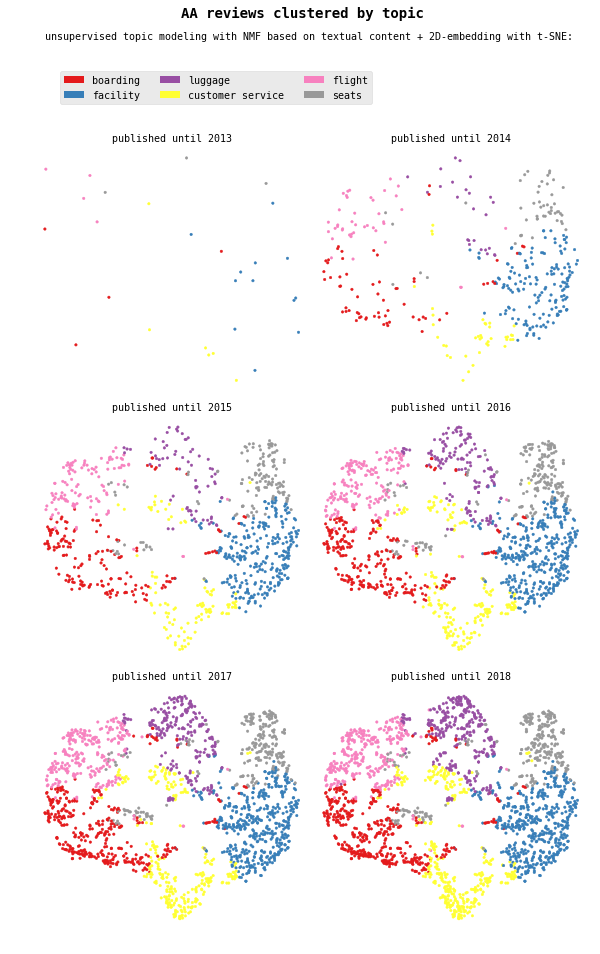

In [70]:
matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')


fig, axs = plt.subplots(3,2, figsize=(10, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

count = 0
legend = []
for year, idx in zip([2013,2014,2015,2016,2017,2018], range(6)):
    data = tsne_embedding[df['year']<=year]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")
    axs[idx].set_title('published until {}'.format(year),**{'fontsize':'10'})
    axs[idx].axis('off')

plt.suptitle("AA reviews clustered by topic",**{'fontsize':'14','weight':'bold'})
plt.figtext(.51,0.95,'unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')


fig.legend(legend_list,topics,loc=(0.1,0.89),ncol=3)
plt.subplots_adjust(top=0.85)

plt.show()

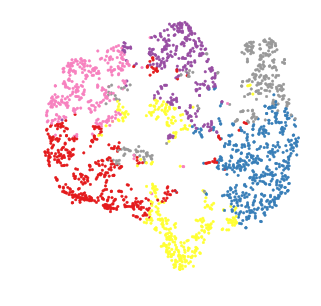

In [63]:
##code used to create the first plot for getting the colors 
plt.style.use('ggplot')

fig, axs = plt.subplots(1,1, figsize=(5, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)

legend_list = []

data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")
plt.axis('off')
plt.show()

colors = []
for i in range(len(topics)):
    idx = np.where(data['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

In [67]:
colors

[array([0.89411765, 0.10196078, 0.10980392, 1.        ]),
 array([0.21568627, 0.49411765, 0.72156863, 1.        ]),
 array([0.59607843, 0.30588235, 0.63921569, 1.        ]),
 array([1. , 1. , 0.2, 1. ]),
 array([0.96862745, 0.50588235, 0.74901961, 1.        ]),
 array([0.6, 0.6, 0.6, 1. ])]

In [72]:
data

,x,y,hue
0,-40.804600,-16.312002,0
1,-34.542599,-11.958870,0
2,-16.485159,-28.085602,0
3,-5.188835,-33.575588,3
4,-20.978901,11.419662,3
5,-40.022636,-25.848642,0
6,-39.429134,-24.956425,0
7,0.359303,-41.284523,3
8,-1.327831,14.120230,2
9,-17.899961,35.599552,2


In [74]:
nmf_embedding

array([[ 2.56869193, -0.69362333,  0.81188903, -0.79498623, -0.28304536,
        -0.24166106],
       [ 1.68899513, -0.78562519, -0.69279079, -0.8876082 , -0.08357188,
        -0.11437995],
       [ 1.09165556, -0.78659372, -0.69279848, -0.08932023, -0.65320427,
        -0.66441074],
       ...,
       [ 1.32113489, -0.78659396,  0.94783214, -0.88760826,  1.04649063,
        -0.66443985],
       [ 1.52578841, -0.7865864 , -0.69279838, -0.88760831, -0.59472523,
        -0.66443985],
       [-0.42031529,  0.90723195, -0.5864973 , -0.87861052, -0.00990857,
        -0.13678719]])

In [75]:
top_idx.T

array([[ 614,  708, 1085],
       [1841, 1213,  442],
       [1094,   57,  630],
       [ 637, 1424,  789],
       [ 778,  887,   36],
       [ 717,  763, 1510]])

In [76]:
top_idx

array([[ 614, 1841, 1094,  637,  778,  717],
       [ 708, 1213,   57, 1424,  887,  763],
       [1085,  442,  630,  789,   36, 1510]])

In [80]:
df["topic"]=[s for s in data.hue]
df.to_csv('AA_reviews2.csv')
data2=pd.read_csv('AA_reviews2.csv')

In [319]:
table = data2[["year","topic","ID"]].groupby(['topic','year']).count()
table = table["ID"].unstack(level=0).fillna(0)
table

topic,0,1,2,3,4,5
year,,,,,,
2013,4.0,12.0,0.0,6.0,4.0,3.0
2014,60.0,149.0,25.0,34.0,37.0,47.0
2015,105.0,123.0,45.0,64.0,71.0,89.0
2016,95.0,102.0,70.0,81.0,66.0,59.0
2017,91.0,71.0,87.0,88.0,71.0,48.0
2018,78.0,39.0,70.0,75.0,53.0,35.0


In [345]:
table_pct_change = table.pct_change()
table_pct_change1 = table_pct_change.iloc[2:,]
table_pct_change1[0]

year
2015    0.750000
2016   -0.095238
2017   -0.042105
2018   -0.142857
Name: 0, dtype: float64

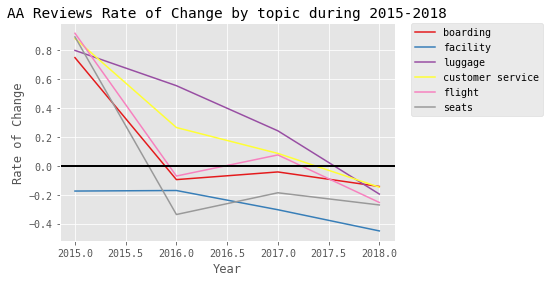

In [351]:
#table_pct_change1.plot(grid=True).axhline(y=0, color="black", lw=2)
with PdfPages('AA_RateOfChange.pdf') as pdf:
    year = [2015,2016,2017,2018]
    
    rate_t0 = table_pct_change1[0]
    rate_t1 = table_pct_change1[1]
    rate_t2 = table_pct_change1[2]
    rate_t3 = table_pct_change1[3]
    rate_t4 = table_pct_change1[4]
    rate_t5 = table_pct_change1[5]

    plt.plot(year, rate_t0, color=[0.89411765, 0.10196078, 0.10980392, 1.        ], label='boarding')
    plt.plot(year, rate_t1, color=[0.21568627, 0.49411765, 0.72156863, 1.        ], label='facility')
    plt.plot(year, rate_t2, color=[0.59607843, 0.30588235, 0.63921569, 1.        ], label='luggage')
    plt.plot(year, rate_t3, color=[1. , 1. , 0.2, 1. ], label='customer service')
    plt.plot(year, rate_t4, color=[0.96862745, 0.50588235, 0.74901961, 1.        ], label='flight')
    plt.plot(year, rate_t5, color=[0.6, 0.6, 0.6, 1. ], label='seats')
    plt.xlabel('Year')
    plt.ylabel('Rate of Change')
    plt.title('AA Reviews Rate of Change by topic during 2015-2018')
    plt.axhline(y=0,color="black", lw=2)
    pdf.savefig()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.close()

In [275]:
topic_id = table.index.get_level_values("topic")
t = [table.loc[topic_id == topic, "ID"] for topic in topic_id.unique()]
t[2]

pandas.core.frame.DataFrame

In [108]:
table.to_csv('count of AA_reviews.csv')

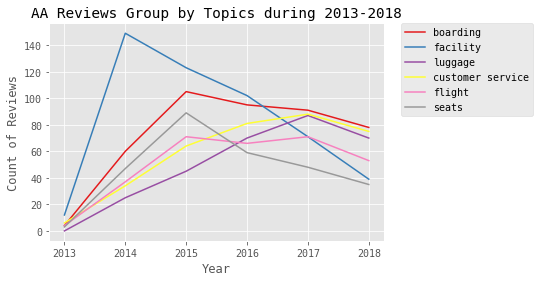

In [316]:
# Number of reviews by year and by topic
with PdfPages('AA_NumberOfReviews.pdf') as pdf:
    year = [2013,2014,2015,2016,2017,2018]

    count_t0 = table[0]
    count_t1 = table[1]
    count_t2 = table[2]
    count_t3 = table[3]
    count_t4 = table[4]
    count_t5 = table[5]

    plt.plot(year, count_t0, color=[0.89411765, 0.10196078, 0.10980392, 1.        ], label='boarding')
    plt.plot(year, count_t1, color=[0.21568627, 0.49411765, 0.72156863, 1.        ], label='facility')
    plt.plot(year, count_t2, color=[0.59607843, 0.30588235, 0.63921569, 1.        ], label='luggage')
    plt.plot(year, count_t3, color=[1. , 1. , 0.2, 1. ], label='customer service')
    plt.plot(year, count_t4, color=[0.96862745, 0.50588235, 0.74901961, 1.        ], label='flight')
    plt.plot(year, count_t5, color=[0.6, 0.6, 0.6, 1. ], label='seats')
    plt.xlabel('Year')
    plt.ylabel('Count of Reviews')
    plt.title('AA Reviews Group by Topics during 2013-2018')
    pdf.savefig()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.close()

In [123]:
table2 = data2[["year","topic","ID"]].groupby(['year','topic']).count()

In [129]:
table3 = data2[["year","ID"]].groupby(['year']).count()

In [130]:
table3

,ID
year,
2013,29
2014,352
2015,497
2016,473
2017,456
2018,350


In [137]:
table4 = table2.join(table3,rsuffix="total")

In [281]:
table4["ratioByYear"]=100*table4.ID/table4.IDtotal

In [276]:
year_id = table4.index.get_level_values("year")
l = [table4.loc[year_id == year, "ratioByYear"] for year in year_id.unique()]
l[0]

pandas.core.series.Series

In [293]:
table5 = table4["ratioByYear"].unstack(level=0).fillna(0)
table5[2013]

topic
0    13.793103
1    41.379310
2     0.000000
3    20.689655
4    13.793103
5    10.344828
Name: 2013, dtype: float64

In [303]:
from matplotlib.backends.backend_pdf import PdfPages

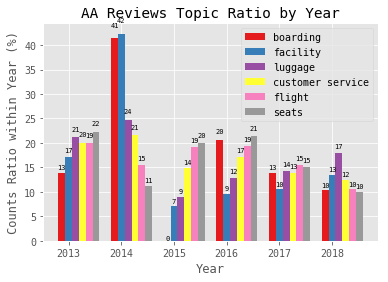

In [318]:
# count ratio by year
with PdfPages('AA_CountRatio.pdf') as pdf:
    N = 6
    ind = np.arange(N)  # the x locations for the groups
    width = 0.13 # the width of the bars

    fig = plt.figure()
    ax = fig.add_subplot(111)

    vals0 = table5[2013]
    rects0 = ax.bar(ind, vals0, width, color=[0.89411765, 0.10196078, 0.10980392, 1.        ])
    vals1 = table5[2014]
    rects1 = ax.bar(ind+width, vals1, width, color=[0.21568627, 0.49411765, 0.72156863, 1.        ])
    vals2 = table5[2015]
    rects2 = ax.bar(ind+width*2, vals2, width, color=[0.59607843, 0.30588235, 0.63921569, 1.        ])
    vals3 = table5[2016]
    rects3 = ax.bar(ind+width*3, vals3, width, color=[1. , 1. , 0.2, 1. ])
    vals4 = table5[2017]
    rects4 = ax.bar(ind+width*4, vals4, width, color=[0.96862745, 0.50588235, 0.74901961, 1.        ])
    vals5 = table5[2018]
    rects5 = ax.bar(ind+width*5, vals5, width, color=[0.6, 0.6, 0.6, 1. ])

    ax.set_xlabel('Year')
    ax.set_ylabel('Counts Ratio within Year (%)')
    plt.title('AA Reviews Topic Ratio by Year')
    pdf.savefig()
    ax.set_xticks(ind+width)
    ax.set_xticklabels( ('2013', '2014', '2015','2016', '2017', '2018') )
    ax.legend( (rects0[0], rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]), ('boarding', 'facility', 'luggage', 'customer service', 'flight', 'seats'))

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                    ha='center', va='bottom', fontsize=7)

    autolabel(rects0)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)

    plt.show()
    plt.close()